# Data Scrapping form the European Medicines Agency (EMA)
## *Miquel Anglada Girotto*

## Load required dependencies

In [3]:
# libraries
library(RSelenium)
library(stringr)

# self-made package
source("EMA_webScrapping.R")

## Set parameters

In [ ]:
# start automated navigator
initRSelenium()

# Navigate to a list of all drugs
url = "https://www.ema.europa.eu/medicines/field_ema_web_categories%253Aname_field/Human/ema_group_types/ema_medicine"
remDr$navigate(url)

# Define pages to look through
page <- "https://www.ema.europa.eu/en/medicines/field_ema_web_categories%253Aname_field/Human/ema_group_types/ema_medicine?page=" #link to navigate through each page of the list.
n <- as.character(round(1495/25)-1) #no. of pages to navigate, as.character() to allow pasting with the 'page' string.

## Download information from each drug

In [ ]:
# Obtain each drug's link
drug_links = getURLs(page,n)

# Use drug links to retrieve information from EMA's webpage for each drug
# (Slow)
drugsDB = getDrugInfo(drug_links)

## Save information in spreadsheet

In [ ]:
# reshape dataframe and fill when features available
drug_df = processTable(drugsDB)

# save
file_name = "drug_df_EMA.csv"
#saveTable(drug_df,file_name)

# Exploratory Data Analysis

In [87]:
# load
drug_df = read.table('drug_df_EMA.csv',sep=',',header=T,stringsAsFactors = F)

In [24]:
# Number of registered drugs
paste('Total EMA registered drugs:',nrow(drug_df))

# Fields names
"Table fields:"
print(colnames(drug_df))

[1] "Total EMA registered drugs: 1272"

[1] "Table fields:"

 [1] "Name"                                                                        
 [2] "Agency.product.number"                                                       
 [3] "Active.substance"                                                            
 [4] "International.non.proprietary.name..INN..or.common.name"                     
 [5] "Therapeutic.area..MeSH."                                                     
 [6] "Anatomical.therapeutic.chemical..ATC..code"                                  
 [7] "Generic"                                                                     
 [8] "Marketing.authorisation.holder"                                              
 [9] "Revision"                                                                    
[10] "Date.of.issue.of.marketing.authorisation.valid.throughout.the.European.Union"
[11] "Contact.address"                                                             
[12] "Additional.monitoring"                                                

## What are the most common therapeutic areas?

In [53]:
# list drugs and their therapeutic area MeSH

# split mesh terms
list_mesh <- lapply(drug_df$Therapeutic.area..MeSH.,split="\n",strsplit)

# add drug names
attributes(list_mesh)$names <- drug_df$Name

# compute total diversity
paste('Diversity in therapeutic areas:',length(unique(list_mesh)))

# compute frequency table of MeSH terms
tab_mesh = table(unlist(list_mesh))
tab_mesh = tab_mesh/length(tab_mesh)

'Top 10:'
sort(tab_mesh,decreasing = T)[1:10]

'Last 10:'
sort(tab_mesh,decreasing = F)[1:10]

[1] "Diversity in therapeutic areas: 509"

[1] "Top 10:"


     Diabetes Mellitus, Type 2                 HIV Infections 
                    0.15839243                     0.14420804 
                  Immunization                   Hypertension 
                    0.12056738                     0.10401891 
              Breast Neoplasms          Myocardial Infarction 
                    0.09929078                     0.09456265 
Carcinoma, Non-Small-Cell Lung          Arthritis, Rheumatoid 
                    0.09219858                     0.08510638 
                        Cancer              Diabetes Mellitus 
                    0.08274232                     0.06855792 

[1] "Last 10:"


                Acromegaly                    Adenoma 
               0.002364066                0.002364066 
Adenomatous Polyposis Coli   Adrenal Cortex Neoplasms 
               0.002364066                0.002364066 
     Adrenal Insufficiency  Alcohol-Related Disorders 
               0.002364066                0.002364066 
        alpha-Mannosidosis      Amyloidosis, Familial 
               0.002364066                0.002364066 
   Anemia, Iron-Deficiency        Anemia, Sickle Cell 
               0.002364066                0.002364066 

## How many drugs are generics?

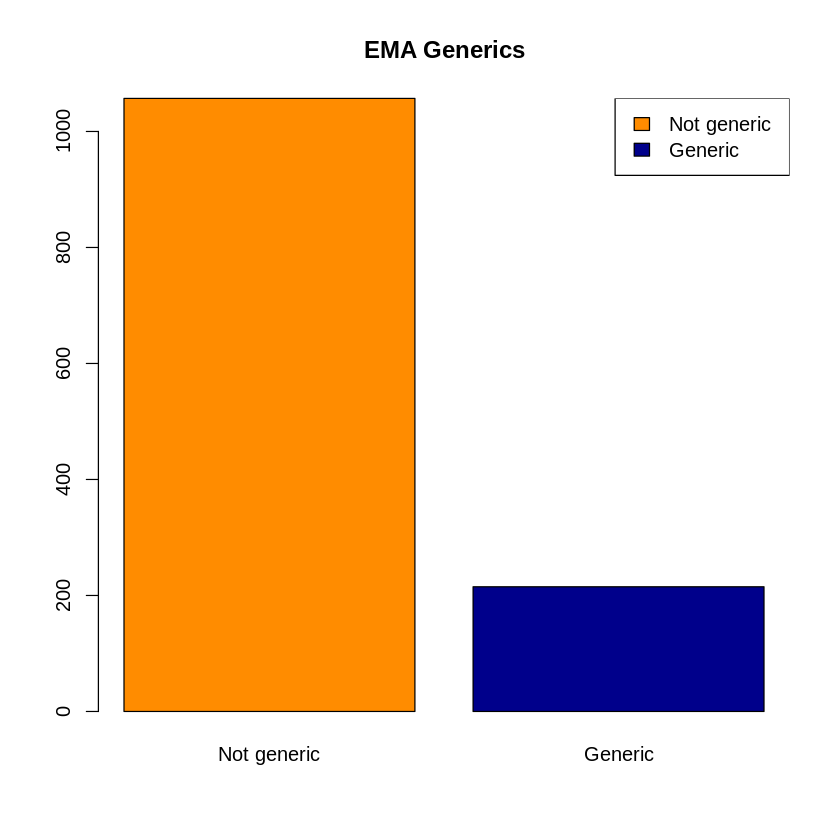

In [79]:
# list drugs and whether they are generic or not
list_gene = drug_df['Generic']!=''
names(list_gene) = drug_df['Name']

# visualize
barplot(table(list_gene), main = 'EMA Generics',col=c('darkorange','darkblue'),names.arg = c('Not generic','Generic'))
legend('topright',legend = c('Not generic','Generic'),fill = c('darkorange','darkblue'))

drug_df$Marketing.authorisation.holder

drug_df$Revision

drug_df$Contact.address

drug_df$Additional.monitoring

drug_df$Orphan

drug_df$Countries

drug_df$Exceptional.circumstances

drug_df$Date.of.issue.of.marketing.authorisation.valid.throughout.the.European.Union